# Computer Vision: Identifying Pnumonia From Chest X-Rays
### Michael Mahoney

# Abstract

## Overal Objectives

## Methodology

# Bussiness Understanding

# Data Understanding

## Package Dependancies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics as skm
import sklearn.preprocessing as skp
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Input, Model, layers, utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.metrics as km
from IPython.display import Image
from PIL import Image as pilImage
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import os
from main import keras_model_wrapper, build_model
import seaborn as sns

tf.__version__
sklearn.__version__

'0.23.2'

Image sizes are not the same

In [2]:
trainPath = './data/chest_xray/train/'
valPath = './data/chest_xray/test/'
testPath ='./data/chest_xray/val/'

In [3]:
im1=pilImage.open('./data/chest_xray/train/NORMAL/IM-0117-0001.jpeg')
im1.size # (width,height) tuple

(1422, 1152)

In [4]:
im1=pilImage.open('./data/chest_xray/train/NORMAL/IM-0115-0001.jpeg')
im1.size # (width,height) tuple

(2090, 1858)

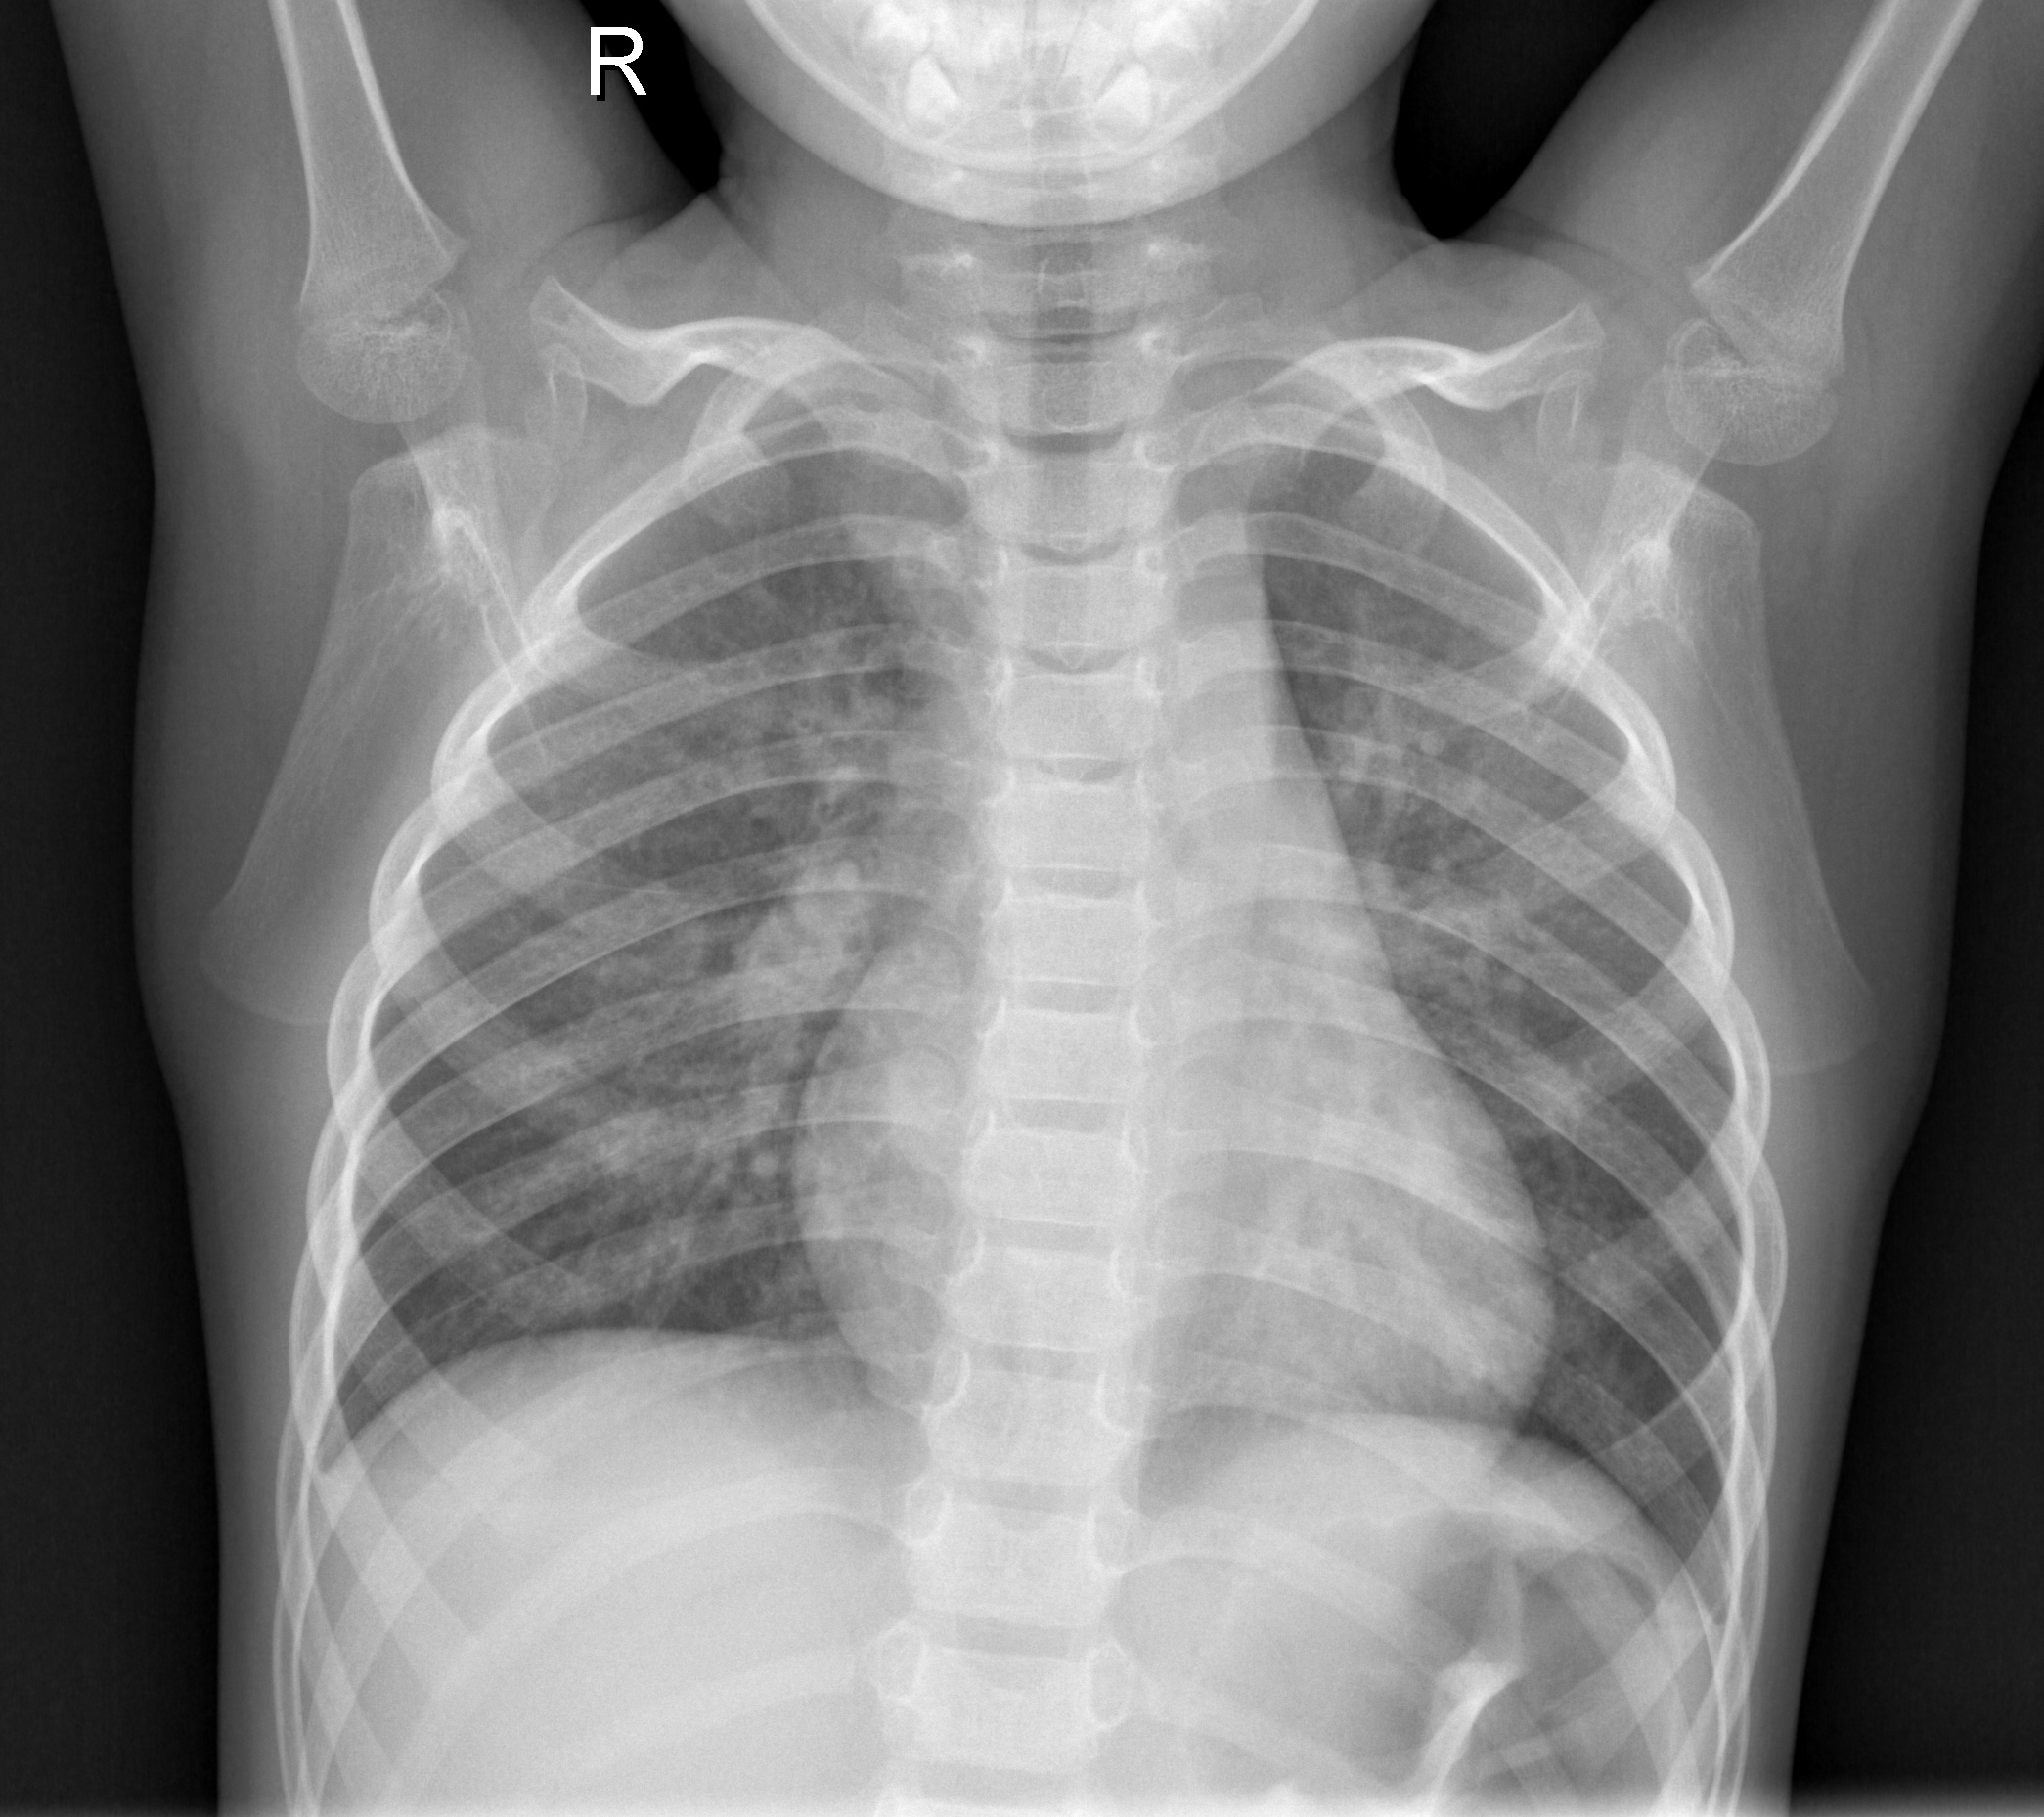

In [5]:
Image(filename='./data/chest_xray/train/NORMAL/IM-0115-0001.jpeg')

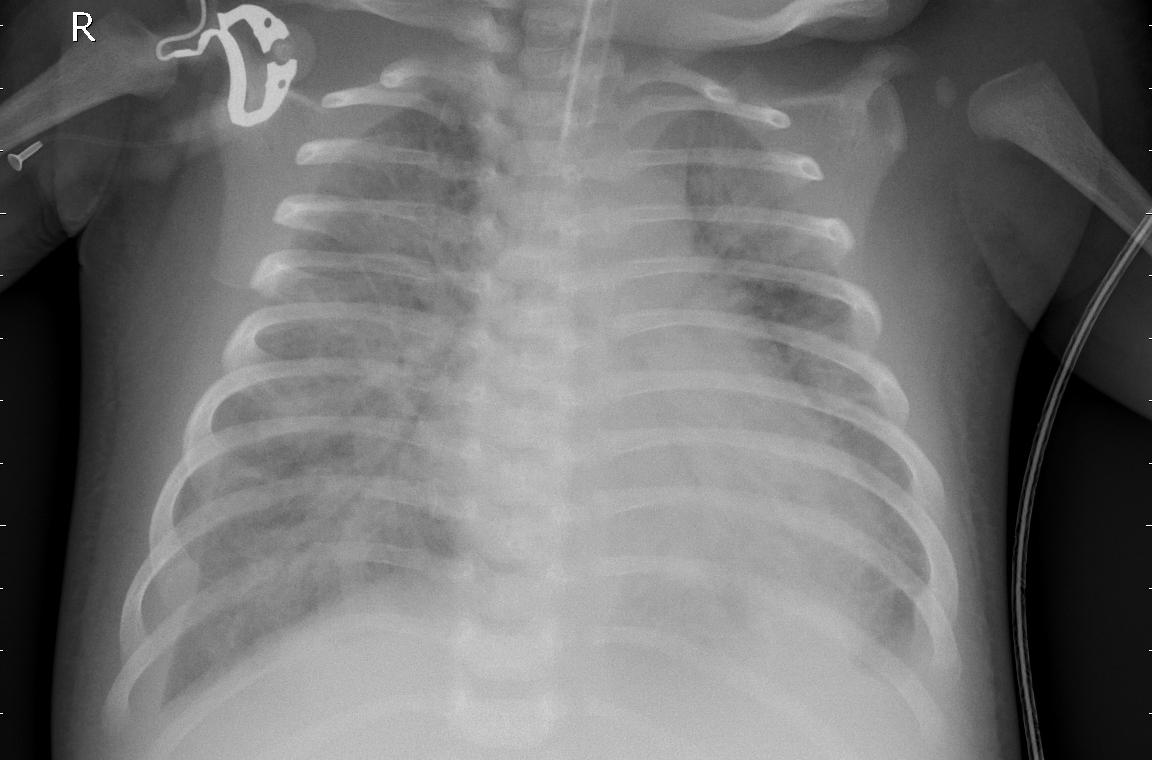

In [242]:
Image(filename='./data/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg')

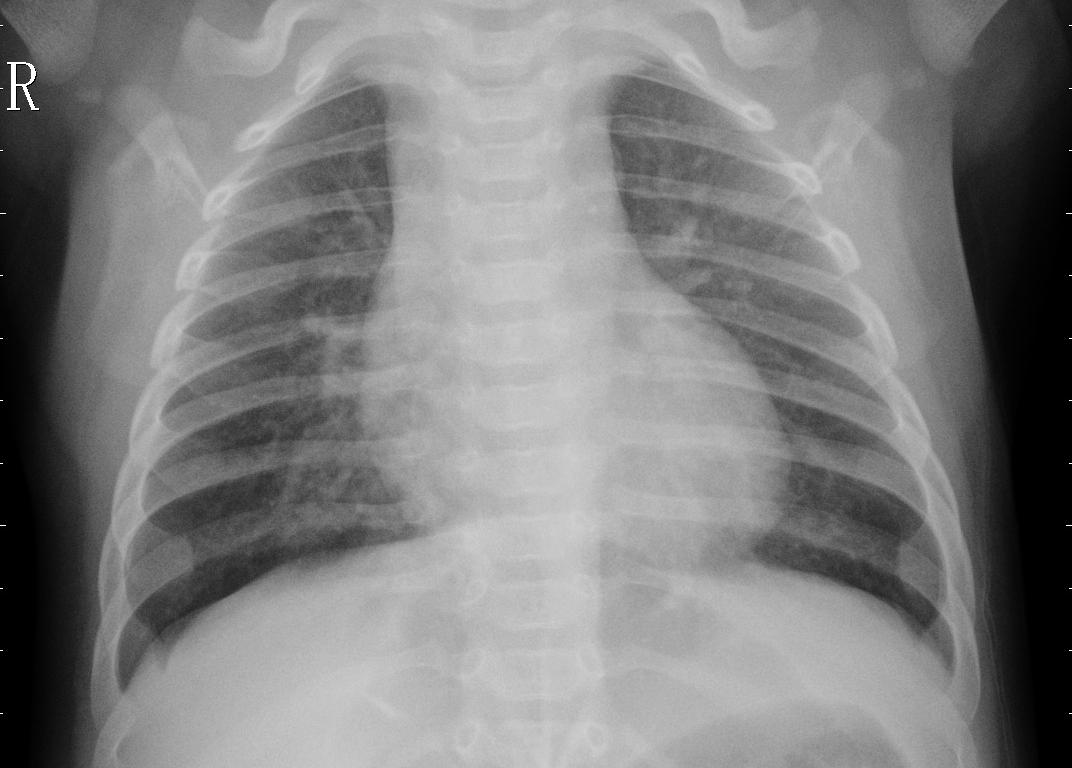

In [244]:
Image(filename='./data/chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg')

In [225]:
train = ImageDataGenerator(
#     samplewise_std_normalization=True,
#     rotation_range=45, 
#     width_shift_range=0.3,
#     height_shift_range=0.3, 
#     shear_range=0.2, 
#     zoom_range=0.3,
#     fill_mode='nearest', 
#     horizontal_flip=True,
#     vertical_flip=True, 
).flow_from_directory(
    trainPath, 
    color_mode='grayscale', 
    class_mode='binary',
    target_size=(256,256),
    batch_size = 5216
)
val = ImageDataGenerator(rescale = 1./255).flow_from_directory(
    valPath, 
    color_mode='grayscale', 
    class_mode='binary',
    target_size=(256,256),
    batch_size = 624
)
test = ImageDataGenerator(rescale = 1./255).flow_from_directory(
    testPath, 
    color_mode='grayscale', 
    class_mode='binary',
    target_size=(256,256),
    batch_size = 16
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [7]:
trainImages, trainImageLabels = next(train)
valImages, valImageLabels = next(val)
testImages, testImageLabels = next(test)

In [8]:
flatTrainImages = trainImages.reshape(5216,-1)
flatValImages = valImages.reshape(624,-1)
flatTestImages = testImages.reshape(16,-1)

# Save the shape of a flattened image in order to feed it into the model
inputShape = flatTrainImages.shape[1]

# The Baseline Model

For the baseline model, this notebook will showcase the general method and explanations for how the neural network is being created. After this first round, several of the coding details will be left out or trimmed down. Rest assured the logic and decision making will still be expounded upon. 

Rather than using a truly dumb model to start off, we will build a very simpe perceptron with only one dense hidden layer. To keep the baseline model straight forward the dense layer will have 256 nodes that correspond to the dimension of the images it will be attempting to classify. There isn't any general sense that this methodology will yield better results, but it will suffice for a starting point for further iterations.

The hidden layer will utilize the "sigmoid" activation function which should be more appropriate for our scaled images, in which each pixel of information lies between the values of 0 and 1. 

The seaching parameters include stocastic gradient decent as the optimizing function, binary_crossentropy as the loss function and various metrics which we will use later on. Srocastic gradient decent (SGD) is the standard optimizer unless we have specific information which would drive us to other methods. As is true for the loss function. 

Metrics will be discussed at length after the model has been created in the baseline model evaluation section.

In [ ]:
# We will be using the keras functional API for building models. 

# define the input layer
baselineModelInputs = Input((inputShape,), name = 'input_layer')

# define the first layer
x1 = layers.Dense(256, activation = 'sigmoid')(baselineModelInputs)

# define the ourput layer
baselineModelOutput = layers.Dense(1, activation = 'sigmoid')(x1)

# Create an instance of the keras.Model class with the input and outputs above
baselineModel = Model(inputs=baselineModelInputs, outputs = baselineModelOutput, name = 'baseline_model')

#compile the model
baselineModel.compile(
    optimizer = 'sgd',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
# This cell defines the call backs we will use for most models. These functions cut down on the amount of time the 
# model takes to run and saves the best result for further use. 

# create the file path for where we want to save the resulting model
baseline_filepath = os.path.join('baseline_model')

# Create a call back that stops the modeling process early if there's no loss function improvement
baselineEarlyStop = EarlyStopping(patience=4, mode = 'max')

# create the call back that will save the best model created in the .fit method and save it to the file path above
baselineModelCheckpoint = ModelCheckpoint(baseline_filepath,save_best_only=True)

In [ ]:
baselineModel.summary()

In [ ]:
# We fit the model, throwing in some basic parameters that will be tuned later. 
baselineHistory = baselineModel.fit(
    flatTrainImages,
    trainImageLabels,
    batch_size=32,
    epochs=25,
    validation_data=(flatValImages, valImageLabels),
    validation_steps=10,
    callbacks=[baselineEarlyStop, baselineModelCheckpoint]  
)

# Baseline Model Evaluation

## Evaluation Metrics

As pnumonia is a medical issue we will be using more metrics than usual when evaluating our models. This notebook will contain the following metrics when evaluating models. 
* Accuracy
* Recall
* F1
* Area Under the Curve (AUC)

### Accuracy

 For general interpretability, we include accuracy. Accuracy is the metric that best gives an answer to the question, "How does my model compare to an average guess." With this problem in particular, the data has a class imbalance. 

In [ ]:
num_p = len([file for file in os.listdir('data./chest_xray/train/PNEUMONIA')])
num_n = len([file for file in os.listdir('data./chest_xray/train/NORMAL')])
print(f'Pneumonia images make up {round((num_p/(num_p+num_n))*100,2)}% of the total Images')
print(f'Normal images make up {round((num_n/(num_p+num_n))*100,2)}% of the total Images')

The cell above suggest that if we weighted a random guess to the proportions of the samples we've been given, we should expect around 74% accuracy on average. In the following two cells, the model is evaluated over the train and test sets, to produce the metrics we are interested in exploring further.

In [ ]:
# Get an evaluation set on the train data
trainEval = np.array(baselineModel.evaluate(flatTrainImages, trainImageLabels)).reshape(1,2)
dfTrainSummary = pd.DataFrame(trainEval, columns = ['Loss_binary_crossentropy', 'Accuracy'])
dfTrainSummary

In [ ]:
# get an evaluation set on the test data
testEval = np.array(baselineModel.evaluate(flatValImages, valImageLabels)).reshape(1,2)
dfTestSummary = pd.DataFrame(testEval, columns = ['Loss_binary_crossentropy', 'Accuracy'])
dfTestSummary

Looking at the accuracy of the testing set, the current neural net doesn't appear to be any better than a random guess. While disappointing first results, there's lots of room for improvement!

In [ ]:
dfBaseline = pd.DataFrame().from_dict(baselineHistory.history)
dfBaseline

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(nrows = 1,ncols = 2, figsize = (14,7))
dfBaseline.plot(y = ['loss', 'val_loss'],ax = ax1);
dfBaseline.plot(y = ['accuracy', 'val_accuracy'],ax = ax2);

The graphs above could represent several issues with the model. For the image on the left, the loss function for the validation doesn't change on average over the 5 epochs, while the training loss continues downward roughly exponentially. The discrepancy is very likely do to overfitting of the training data. 

For the image on the right we see the training accuracy increasing logrithmicaly and the validation set ocillating around 75% accuracy. This is very likely do the simplicity of our model not being able to capture useful information about the images in the two dense layers in the baseline model. This is why we see the average accuracy very near what we would expect with a blind guess. The information the model picked up from the training set was particular enough to generalize to images it had never seen before.

For the following models, we will take a much deeper dive into model metrics (as well as indroduce several more). Considering this model is barely treding above a random guess, we will omit a more surgical analysis and move on to the next model. 

# Second Model

## Changes

The simple dense layer model used as the baseline wasn't taylored to image classification. There are, however, several other layer types that are much more adept at picking up on the data structure of images. The second model will rely on convulutional and pooling layers. 

A true deep dive into the underlying workings of these layers is beyond the scope of this notebook but we will sum them up for convienence. 

### Convulutional layers 

Convulutional layers are the life force of modern neural network image processing. Unlike dense layers which connect every piece of a 

### Pooling Layers

In [9]:
def dummy_function():
    return (build_model(modelLayers = [
        Input(shape = (256,256,1), name = 'input_layer'),
        layers.Conv2D(8, activation = 'relu',kernel_size = (5,5),padding = 'same' ),
        layers.MaxPool2D(2, padding = 'same'),
        layers.Conv2D(8, activation = 'relu',kernel_size = (5,5),padding = 'same' ),
        layers.MaxPool2D(2, padding = 'same'),
        layers.Flatten(),
        layers.Dense(128, activation = 'relu'),
        layers.Dense(1, activation = 'sigmoid'),
    ],
    model_name = 'second_model',
    optimizer =  'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
    ))

In [10]:
secondModel_filepath = os.path.join('second_model')
secondModelEarlyStop = EarlyStopping(patience=4, mode = 'auto')
secondModelCheckpoint = ModelCheckpoint(secondModel_filepath,save_best_only=True)

In [11]:
secondModel = KerasClassifier(
    dummy_function, 
    batch_size=64,
    epochs=20,
    validation_data= (valImages, valImageLabels),
    validation_steps=10,
    callbacks=[secondModelEarlyStop, secondModelCheckpoint])

In [12]:
secondModel.fit(trainImages, trainImageLabels)

82/82 [==============================] - 79s 968ms/step - loss: 0.3392 - accuracy: 0.8869 - val_loss: 0.6386 - val_accuracy: 0.7692


In [49]:
secondModel.model.evaluate(trainImages, trainImageLabels)

163/163 [==============================] - 19s 115ms/step - loss: 0.1002 - accuracy: 0.9668


[0.10023069381713867, 0.9668328166007996]

In [50]:
secondModel.model.evaluate(valImages, valImageLabels)

20/20 [==============================] - 2s 108ms/step - loss: 0.6386 - accuracy: 0.7692


[0.6386433243751526, 0.7692307829856873]

In [36]:
y_hat_train = secondModel.predict(trainImages)
y_train = trainImageLabels

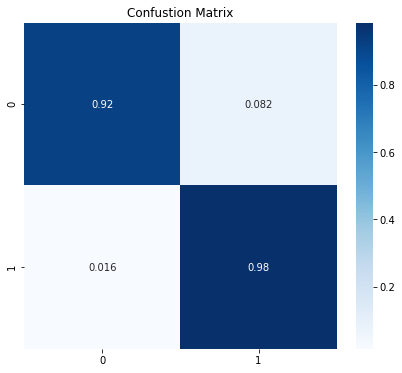

In [44]:
def confustion_matrix(y, y_hat, normalize = 'true'):
    fig, ax = plt.subplots(1,1,figsize = (7,6))
    matrix = skm.confusion_matrix(y, y_hat, normalize=normalize,)
    sns.heatmap(matrix, cmap = 'Blues', annot=True, ax = ax)
    ax.set(
        title = 'Confustion Matrix')
    
confustion_matrix(y_train, y_hat_train)

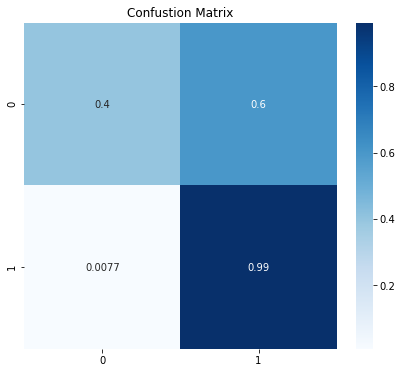

In [45]:
y_hat_val = secondModel.predict(valImages)
y_val = valImageLabels
confustion_matrix(y_val, y_hat_val)

Once again we add some callback functions for efficiancy and reusability. 

In [ ]:
testEval = np.array(secondModel.evaluate(valImages, valImageLabels)).reshape(1,2)
dfValidationSummary = pd.DataFrame(testEval, columns = ['Loss_binary_crossentropy', 'Accuracy'])
dfValidationSummary

In [ ]:
dfSecondModel = pd.DataFrame.from_dict(secondModelHistory.history)
dfSecondModel.plot()

# Second Model Evaluation

The second model was much more stable. Metrics aren't that impressive which means we are likely dealing with training overfitting. There are several prescribed methods to handle overfitting but we will explore some more detailed metrics to see if we can tease out what part of our model is preforming incorrectly. 

In [ ]:
thing = Sequential()
thing.add(secondModel)

In [ ]:
thing.compile(optimizer='adam', loss = 'binary_crossentropy')
thing.fit(trainImages,trainImageLabels)

In [ ]:
secondModelSklearn = KerasClassifier(secondModel)
secondModelSklearn.

In [ ]:
y_hat_train = secondModel.predict(trainImages)
secondModelSklearn.score(trainImages, trainImageLabels)

# Third Model

## Changes

The 

In [334]:
train = \
    ImageDataGenerator(
        rescale=1.255,
        rotation_range=45, 
        width_shift_range=0.3,
        height_shift_range=0.3, 
        shear_range=0.2, 
        zoom_range=0.3,
        fill_mode='nearest', 
        horizontal_flip=True,
        vertical_flip=True)\
    .flow_from_directory(
        trainPath, 
        color_mode='grayscale', 
        class_mode='binary',
        target_size=(256,256),
        batch_size = 5216)
val = \
    ImageDataGenerator(
        rescale=1.255,
        rotation_range=45, 
        width_shift_range=0.3,
        height_shift_range=0.3, 
        shear_range=0.2, 
        zoom_range=0.3,
        fill_mode='nearest', 
        horizontal_flip=True,
        vertical_flip=True)\
    .flow_from_directory(
        valPath, 
        color_mode='grayscale', 
        class_mode='binary',
        target_size=(256,256),
        batch_size = 624)
test = \
    ImageDataGenerator(
        rescale=1.255,
        rotation_range=45, 
        width_shift_range=0.3,
        height_shift_range=0.3, 
        shear_range=0.2, 
        zoom_range=0.3,
        fill_mode='nearest', 
        horizontal_flip=True,
        vertical_flip=True)\
    .flow_from_directory(
        testPath, 
        color_mode='grayscale', 
        class_mode='binary',
        target_size=(256,256),
        batch_size = 16)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [335]:
trainImages, trainImageLabels = next(train)
valImages, valImageLabels = next(val)
testImages, testImageLabels = next(test)

In [365]:
thirdModelBuild = build_model(
    modelLayers = [
        Input(shape = (256,256,1), name = 'input_layer'),
        layers.Conv2D(16,kernel_size = (3,3),padding = 'same'),
        layers.ReLU(),
        layers.Conv2D(16,kernel_size = (3,3),padding = 'same'),
        layers.ReLU(),
        layers.MaxPool2D(2, padding = 'same'),
        layers.Conv2D(16,kernel_size = (3,3),padding = 'same'),
        layers.ReLU(),
        layers.Conv2D(16,kernel_size = (3,3),padding = 'same'),
        layers.ReLU(),
        layers.MaxPool2D(2, padding = 'same'),
        layers.Flatten(),
        layers.Dense(1, activation = 'sigmoid'),     
    ],
    model_name = 'third_model',
    optimizer =  'rmsprop',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
    )
thirdModelBuild.get_layer(name = 'third_model').summary()

Model: "third_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_280 (Conv2D)          (None, 256, 256, 16)      160       
_________________________________________________________________
re_lu_210 (ReLU)             (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_281 (Conv2D)          (None, 256, 256, 16)      2320      
_________________________________________________________________
re_lu_211 (ReLU)             (None, 256, 256, 16)      0         
_________________________________________________________________
max_pooling2d_161 (MaxPoolin (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_282 (Conv2D)          (None, 128, 128, 16)      

In [366]:
def build_third_model():
    return thirdModelBuild

In [367]:
thirdModel_filepath = os.path.join('third_model')
thirdModelEarlyStop = EarlyStopping(patience=6, mode = 'auto')
thirdModelCheckpoint = ModelCheckpoint(thirdModel_filepath,save_best_only=True)

In [368]:
thirdModel = KerasClassifier(
    build_third_model, 
    batch_size=32,
    epochs=20,
    validation_data= (valImages, valImageLabels),
    validation_steps=10,
    class_weight = {0:10, 1:1},
    callbacks=[thirdModelEarlyStop, thirdModelCheckpoint])

In [369]:
thirdModel.fit(trainImages, trainImageLabels)

Epoch 1/20
163/163 [==============================] - 209s 1s/step - loss: 561271.6250 - accuracy: 0.4647 - val_loss: 87365.6875 - val_accuracy: 0.3969
Epoch 2/20
163/163 [==============================] - 213s 1s/step - loss: 53108.4102 - accuracy: 0.2772 - val_loss: 30866.4902 - val_accuracy: 0.4187
Epoch 3/20
163/163 [==============================] - 204s 1s/step - loss: 29654.1543 - accuracy: 0.4799 - val_loss: 29950.0469 - val_accuracy: 0.7125
Epoch 4/20
163/163 [==============================] - 205s 1s/step - loss: 15951.9697 - accuracy: 0.5470 - val_loss: 8654.6406 - val_accuracy: 0.6781
Epoch 5/20
163/163 [==============================] - 213s 1s/step - loss: 6908.7134 - accuracy: 0.5855 - val_loss: 2867.1587 - val_accuracy: 0.7656
Epoch 6/20
163/163 [==============================] - 210s 1s/step - loss: 2509.7549 - accuracy: 0.6001 - val_loss: 746.7917 - val_accuracy: 0.6687
Epoch 7/20
163/163 [==============================] - 209s 1s/step - loss: 239.2019 - accuracy: 0.5

KeyboardInterrupt: 

In [ ]:
thirdModel.model.evaluate(trainImages, trainImageLabels)
thirdModel.model.evaluate(valImages, valImageLabels)

In [ ]:
thirdModel.model.evaluate(valImages, valImageLabels)

In [ ]:
y3_hat_train = thirdModel.predict(trainImages)
y3_train = trainImageLabels
confustion_matrix(y3_train, y3_hat_train)
y3_hat_val = thirdModel.predict(valImages)
y3_val = valImageLabels
confustion_matrix(y3_val, y3_hat_val)
confustion_matrix(y3_val, y3_hat_val, normalize=None)

# Fourth Model

In [328]:
fourthModelBuild = build_model(
    modelLayers = [
        Input(shape = (256,256,1), name = 'input_layer'),
        layers.Conv2D(49,kernel_size = (7,7),padding = 'same' ),
        layers.ReLU(),
        layers.Conv2D(25,kernel_size = (5,5),padding = 'same' ),
        layers.ReLU(),
        layers.MaxPool2D(2, padding = 'same'),
        layers.Conv2D(25,kernel_size = (5,5),padding = 'same' ),
        layers.ReLU(),
        layers.Conv2D(9,kernel_size = (3,3),padding = 'same' ),
        layers.ReLU(),
        layers.MaxPool2D(),
#         layers.Conv2D(16,kernel_size = (9,9),padding = 'same' ),
#         layers.ReLU(threshold = 1, negative_slope = .5),
#         layers.Conv2D(16,kernel_size = (11,11),padding = 'same' ),
#         layers.ReLU(threshold = 1, negative_slope = .5),
#         layers.MaxPool2D(2, padding = 'same'),
        layers.Flatten(),
        layers.Dense(1, activation = 'sigmoid'),
        
    ],
    model_name = 'fourth_model',
    optimizer =  'nadam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
    )
fourthModelBuild.get_layer(name = 'fourth_model').summary()

Model: "fourth_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_218 (Conv2D)          (None, 256, 256, 49)      2450      
_________________________________________________________________
re_lu_148 (ReLU)             (None, 256, 256, 49)      0         
_________________________________________________________________
conv2d_219 (Conv2D)          (None, 256, 256, 25)      30650     
_________________________________________________________________
re_lu_149 (ReLU)             (None, 256, 256, 25)      0         
_________________________________________________________________
max_pooling2d_155 (MaxPoolin (None, 128, 128, 25)      0         
_________________________________________________________________
conv2d_220 (Conv2D)          (None, 128, 128, 25)     

In [317]:
def build_fourth_model():
    return fourthModelBuild

In [318]:
fourthModel_filepath = os.path.join('fourth_model')
fourthModelEarlyStop = EarlyStopping(patience=6, mode = 'auto')
fourthModelCheckpoint = ModelCheckpoint(fourthModel_filepath,save_best_only=True)

In [319]:
fourthModel = KerasClassifier(
    build_fourth_model, 
    batch_size=64,
    epochs=25,
    validation_data= (valImages, valImageLabels),
    class_weight = {0:10, 1:1},
    callbacks=[fourthModelEarlyStop, fourthModelCheckpoint])

In [320]:
fourthModel.fit(trainImages, trainImageLabels)

Epoch 1/25
82/82 [==============================] - 1036s 13s/step - loss: 1.8840 - accuracy: 0.2682 - val_loss: 0.7855 - val_accuracy: 0.3766
Epoch 2/25
82/82 [==============================] - 1046s 13s/step - loss: 2.2432 - accuracy: 0.2782 - val_loss: 0.9160 - val_accuracy: 0.3750
Epoch 3/25
82/82 [==============================] - 1005s 12s/step - loss: 1.6047 - accuracy: 0.3702 - val_loss: 0.5773 - val_accuracy: 0.7115
Epoch 4/25
82/82 [==============================] - 1087s 13s/step - loss: 1.2921 - accuracy: 0.5422 - val_loss: 0.5412 - val_accuracy: 0.7708
Epoch 5/25
82/82 [==============================] - 1770s 22s/step - loss: 0.8997 - accuracy: 0.7291 - val_loss: 0.5945 - val_accuracy: 0.7676
Epoch 6/25
82/82 [==============================] - 1778s 22s/step - loss: 0.6950 - accuracy: 0.7977 - val_loss: 1.1018 - val_accuracy: 0.6699
Epoch 7/25
82/82 [==============================] - 1771s 22s/step - loss: 0.5527 - accuracy: 0.8378 - val_loss: 0.5705 - val_accuracy: 0.8189

In [321]:
fourthModel.model.evaluate(trainImages, trainImageLabels)
fourthModel.model.evaluate(valImages, valImageLabels)

20/20 [==============================] - 23s 1s/step - loss: 0.7747 - accuracy: 0.8013


[0.7747179269790649, 0.8012820482254028]

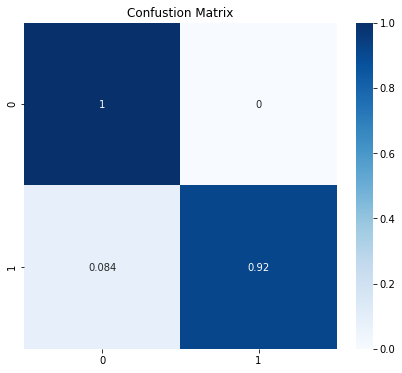

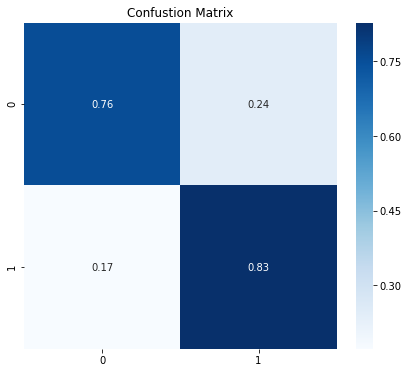

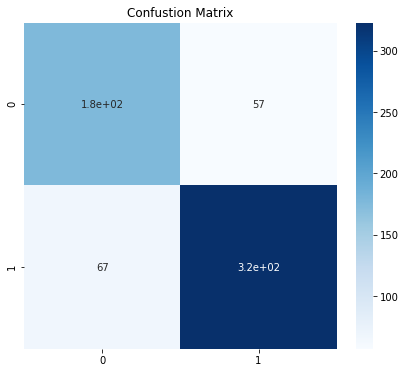

In [322]:
y4_hat_train = fourthModel.predict(trainImages)
y4_train = trainImageLabels
confustion_matrix(y4_train, y4_hat_train)
y4_hat_val = fourthModel.predict(valImages)
y4_val = valImageLabels
confustion_matrix(y4_val, y4_hat_val)
confustion_matrix(y4_val, y4_hat_val, normalize=None)

# Fifth Model

In [439]:
fifthModelBuild = build_model(
    modelLayers = [
        Input(shape = (256,256,1), name = 'input_layer'),
        layers.Conv2D(27,kernel_size = (3,3),padding = 'same', strides = 1),
        layers.BatchNormalization(axis = 3, scale = False),
        layers.ReLU(),
        layers.Conv2D(27,kernel_size = (3,3),padding = 'same', strides = 1, kernel_regularizer = 'l2'),
        layers.BatchNormalization(axis = 3, scale = False),
        layers.ReLU(),
        layers.Conv2D(27,kernel_size = (3,3),padding = 'same', strides=1),
        layers.BatchNormalization(axis = 3, scale = False),
        layers.ReLU(),
        layers.Conv2D(27,kernel_size = (3,3),padding = 'same', strides = 2, kernel_regularizer = 'l2'),
        layers.BatchNormalization(axis = 3, scale = False),
        layers.ReLU(),
        layers.Conv2D(27,kernel_size = (3,3),padding = 'same',strides = 2, ),
        layers.BatchNormalization(axis = 3, scale = False),
        layers.ReLU(),
        layers.Conv2D(27,kernel_size = (3,3),padding = 'same',strides = 2, kernel_regularizer = 'l2'),
        layers.BatchNormalization(axis = 3, scale = False),
        layers.ReLU(),
        layers.Conv2D(27,kernel_size = (3,3),padding = 'same',strides = 2 ),
        layers.BatchNormalization(axis = 3, scale = False),
        layers.ReLU(),
        layers.Flatten(),
        layers.Dropout(.3),
        layers.Dense(1, activation = 'sigmoid'),
        
    ],
    model_name = 'fifth_model',
    optimizer =  'nadam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
    )
fifthModelBuild.get_layer(name = 'fifth_model').summary()

Model: "fifth_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_388 (Conv2D)          (None, 256, 256, 27)      270       
_________________________________________________________________
batch_normalization_27 (Batc (None, 256, 256, 27)      81        
_________________________________________________________________
re_lu_314 (ReLU)             (None, 256, 256, 27)      0         
_________________________________________________________________
conv2d_389 (Conv2D)          (None, 256, 256, 27)      6588      
_________________________________________________________________
batch_normalization_28 (Batc (None, 256, 256, 27)      81        
_________________________________________________________________
re_lu_315 (ReLU)             (None, 256, 256, 27)      

In [428]:
def build_fifth_model():
    return fourthModelBuild

In [429]:
fifthModel_filepath = os.path.join('fifth_model')
fifthModelEarlyStop = EarlyStopping(patience=6, mode = 'auto', restore_best_weights = True)
fifthModelCheckpoint = ModelCheckpoint(fifthModel_filepath,save_best_only=True)

In [430]:
fifthModel = KerasClassifier(
    build_fifth_model, 
    batch_size=64,
    epochs=25,
    validation_data= (valImages, valImageLabels),
    class_weight = {0:10, 1:1},
    callbacks=[fifthModelEarlyStop, fifthModelCheckpoint])

In [431]:
fifthModel.fit(trainImages, trainImageLabels)

Epoch 1/25
82/82 [==============================] - 1033s 13s/step - loss: 0.3377 - accuracy: 0.9289 - val_loss: 3.0116 - val_accuracy: 0.7244
Epoch 2/25
82/82 [==============================] - 1177s 14s/step - loss: 0.3695 - accuracy: 0.9204 - val_loss: 3.2407 - val_accuracy: 0.7372
Epoch 3/25
 2/82 [..............................] - ETA: 9:31 - loss: 0.2244 - accuracy: 0.9297

KeyboardInterrupt: 

In [443]:
fifthModel.model.evaluate(trainImages, trainImageLabels)
fifthModel.model.evaluate(valImages, valImageLabels)

10/10 [==============================] - 22s 2s/step - loss: 3.2275 - accuracy: 0.7388


[3.2274978160858154, 0.7387820482254028]

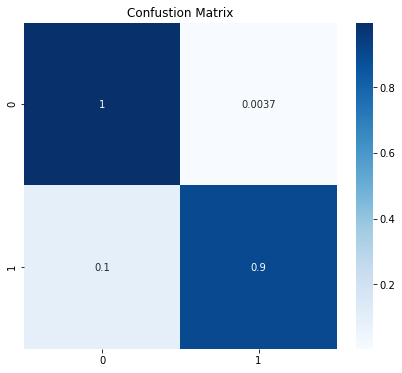

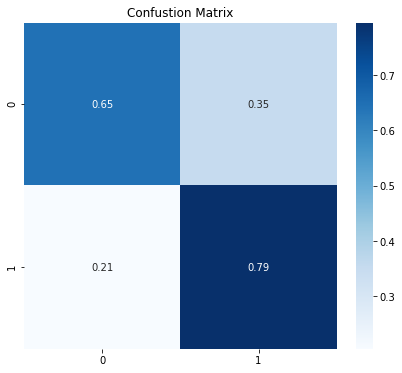

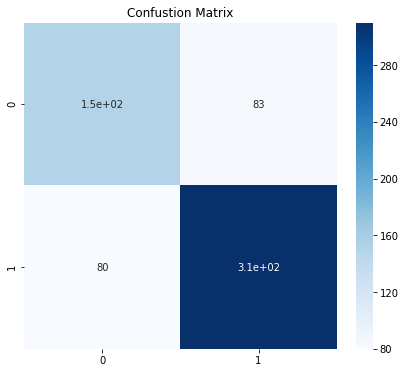

In [444]:
y5_hat_train = fifthModel.predict(trainImages)
y5_train = trainImageLabels
confustion_matrix(y5_train, y5_hat_train)
y5_hat_val = fifthModel.predict(valImages)
y5_val = valImageLabels
confustion_matrix(y5_val, y5_hat_val)
confustion_matrix(y5_val, y5_hat_val, normalize=None)

# Experimental Modles

## Residual Net

In [530]:
inputs = Input(shape = (256,256,1), name = 'input_layer')
x = layers.Conv2D(27,kernel_size = (3,3),padding = 'same', strides=1)(inputs)
x = layers.BatchNormalization(axis = 3, scale = False)(x)
x = layers.LeakyReLU(.1)(x)

resid1 = layers.Conv2D(27,kernel_size = (3,3),padding = 'same', strides = 2)(x)
x = layers.BatchNormalization(axis = 3, scale = False)(resid1)
x = layers.LeakyReLU(.1)(x)
x = layers.Conv2D(27,kernel_size = (3,3),padding = 'same', strides = 1, kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(axis = 3, scale = False)(x)
x = layers.LeakyReLU(.1)(x)
x = layers.Conv2D(27,kernel_size = (3,3),padding = 'same', strides=1)(x)
x = layers.BatchNormalization(axis = 3, scale = False)(x)
x = layers.LeakyReLU(.1)(x)

block1 = layers.add([resid1,x])
resid2 = layers.Conv2D(27,kernel_size = (3,3),padding = 'same', strides = 2, kernel_regularizer = 'l2')(block1)
x = layers.BatchNormalization(axis = 3, scale = False)(resid2)
x = layers.LeakyReLU(.1)(x)
x = layers.Conv2D(27,kernel_size = (3,3),padding = 'same',strides = 1, kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(axis = 3, scale = False)(x)
x = layers.LeakyReLU(.1)(x)

block2 = layers.add([x, resid2])
resid3 = layers.Conv2D(27,kernel_size = (3,3),padding = 'same',strides = 2)(block2)
x = layers.BatchNormalization(axis = 3, scale = False)(resid3)
x = layers.LeakyReLU(.1)(x)
x = layers.Conv2D(27,kernel_size = (3,3),padding = 'same',strides = 1)(x)
x = layers.BatchNormalization(axis = 3, scale = False)(x)
x = layers.LeakyReLU(.1)(x)

block3 = layers.add([x, resid3])
resid4 = layers.Conv2D(27,kernel_size = (3,3),padding = 'same',strides = 2)(block3)
x = layers.BatchNormalization(axis = 3, scale = False)(resid4)
x = layers.LeakyReLU(.1)(x)
x = layers.Conv2D(27,kernel_size = (3,3),padding = 'same',strides = 1)(x)
x = layers.BatchNormalization(axis = 3, scale = False)(x)
x = layers.LeakyReLU(.1)(x)

block4 = layers.add([x, resid4])
resid5 = layers.Conv2D(27,kernel_size = (3,3),padding = 'same',strides = 2)(block4)
x = layers.BatchNormalization(axis = 3, scale = False)(resid5)
x = layers.LeakyReLU(.1)(x)
x = layers.Conv2D(27,kernel_size = (3,3),padding = 'same',strides = 1)(x)
x = layers.BatchNormalization(axis = 3, scale = False)(x)
x = layers.LeakyReLU(.1)(x)

x = layers.Flatten()(x)
x = layers.Dropout(.3)(x)

outputs = layers.Dense(1, activation = 'sigmoid')(x)

experimentalModel1 = Model(inputs = inputs, outputs = outputs, name = 'experimental_model_1')
experimentalModel1.summary()

Model: "experimental_model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_622 (Conv2D)             (None, 256, 256, 27) 270         input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_254 (BatchN (None, 256, 256, 27) 81          conv2d_622[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_80 (LeakyReLU)      (None, 256, 256, 27) 0           batch_normalization_254[0][0]    
_______________________________________________________________________________

In [531]:
experimentalModel1.compile(
    optimizer =  'rmsprop',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [532]:
experimental1Model_filepath = os.path.join('exmodel1')
experimental1ModelEarlyStop = EarlyStopping(patience=8, mode = 'auto')
experimental1ModelCheckpoint = ModelCheckpoint(experimental1Model_filepath,save_best_only=True)

In [533]:
experimentalModel1.fit(
    trainImages, 
    trainImageLabels,
    epochs=50,
    batch_size=64,
    validation_split=.1,
    class_weight = {0:4, 1:1},
    callbacks=[experimental1ModelCheckpoint, experimental1ModelEarlyStop]
)

Epoch 1/50
74/74 [==============================] - 461s 6s/step - loss: 1.7003 - accuracy: 0.6845 - val_loss: 1.5823 - val_accuracy: 0.7146
Epoch 2/50
74/74 [==============================] - 472s 6s/step - loss: 1.1248 - accuracy: 0.8268 - val_loss: 0.9565 - val_accuracy: 0.7318
Epoch 3/50
74/74 [==============================] - 478s 6s/step - loss: 0.9228 - accuracy: 0.8470 - val_loss: 0.6250 - val_accuracy: 0.8716
Epoch 4/50
74/74 [==============================] - 472s 6s/step - loss: 0.7747 - accuracy: 0.8639 - val_loss: 1.0808 - val_accuracy: 0.7222
Epoch 5/50
74/74 [==============================] - 477s 6s/step - loss: 0.6477 - accuracy: 0.8756 - val_loss: 0.5009 - val_accuracy: 0.8544
Epoch 6/50
74/74 [==============================] - 472s 6s/step - loss: 0.5983 - accuracy: 0.8875 - val_loss: 0.7917 - val_accuracy: 0.7050
Epoch 7/50
74/74 [==============================] - 475s 6s/step - loss: 0.4907 - accuracy: 0.9052 - val_loss: 0.8477 - val_accuracy: 0.7299
Epoch 8/50
74

KeyboardInterrupt: 

In [ ]:
experimentalModel1.evaluate(trainImages, trainImageLabels)
experimentalModel1.evaluate(valImages, valImageLabels)
yex1_hat_train = experimentalModel1.predict(trainImages).round()
yex1_train = trainImageLabels
confustion_matrix(yex1_train, yex1_hat_train)
yex1_hat_val = experimentalModel1.predict(valImages).round()
yex1_val = valImageLabels
confustion_matrix(yex1_val, yex1_hat_val)
confustion_matrix(yex1_val, yex1_hat_val, normalize=None)

# Business Insights and Conclusions

# Deployment

# Future Work